In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import empyrical
%matplotlib inline

In [2]:
def metric(ret):
    an_ret = empyrical.annual_return(ret, period='monthly')
    vol = empyrical.annual_volatility(ret, period='monthly')
    maxdraw = empyrical.max_drawdown(ret)
    print('Annual return: %.2f%%'%(an_ret*100))
    print('Sharpe ratio: %.2f'%(an_ret / vol))
    print('Annual volatility: %.2f%%'%(vol*100))
    print('Max drawdown: %.2f%%'%(maxdraw*100))

# 读取数据

In [44]:
wind = pd.read_excel('../data/wind.xlsx', index_col=0)

In [45]:
wind.tail()

,Wind Index,Wind Index PE
881001.WI,,
2019-01-31,3333.4650,13.634300
2019-02-28,3928.2468,16.445101
2019-03-29,4241.5262,17.484501
2019-04-30,4180.4348,17.776800
2019-05-31,3913.6616,16.662600


In [53]:
df = pd.read_excel(u'../data/global strategy data.xlsx', sheet_name='data', index_col=0)

In [54]:
df.tail()

,SHCOMP Index,HSI Index,SPXT Index,LUATTRUU Index,CNDR1Y index,SHCOMP Index PE,HSI Index PE,SPX Index PE,FDTRMID Index
1997-12-31 00:00:00,,,,,,,,,
2019-01-31,3679.0522,48715.9387,36072.47445,2228.135,1.5,12.7806,10.8350,17.8226,2.375
2019-02-28,4186.3485,49965.6539,37193.47711,2222.100,1.5,14.5389,11.1028,18.3580,2.375
2019-03-29,4399.9193,50900.1080,38020.42197,2264.523,1.5,14.9193,11.4046,18.6156,2.375
2019-04-30,4383.5161,52252.3762,39693.63159,2258.236,1.5,14.8728,11.6589,19.3267,2.375
2019-05-31,4139.6283,49097.8631,38111.11128,2311.308,1.5,14.0159,10.5605,18.0404,2.375


In [55]:
df = df.merge(wind, left_index=True, right_index=True)

In [56]:
a_stock, hk_stock, us_stock = 'Wind Index', 'HSI Index', 'SPXT  Index'
asset_columns = [a_stock, hk_stock, us_stock, 'LUATTRUU Index']

In [57]:
assets_ret = df[asset_columns].pct_change()

In [58]:
fed_rate = df['FDTRMID Index']

# 计算估值偏离

In [59]:
pe = df[['Wind Index PE', 'HSI Index PE', 'SPX Index PE']]

In [60]:
pe_dev = (pe - pe.rolling(60).mean()) / pe.rolling(60).mean()

In [61]:
pe_dev = pe_dev.dropna()

# 回测

In [62]:
# 判断当前状态
def regime_weight(date):
    rate_change = fed_rate[fed_rate.index <= date].diff(3).iloc[-1]
    if rate_change == 0:
        return np.array([0.3, 0.3, 0.3, 0.1])
    elif rate_change > 0:
        return np.array([1./3, 1./3, 1./3, 0.])
    else:
        return np.array([0.8/3, 0.8/3, 0.8/3, 0.2])

In [63]:
def weight_change(w, dev):
    if dev < -0.3:
        return w + 0.35
    elif -0.3 <= dev and dev < -0.2:
        return w + 0.25
    elif -0.2 <= dev and dev < -0.1:
        return w + 0.15
    elif 0.1 <= dev and dev < 0.2:
        return max(0, w - 0.15)
    elif 0.2 <= dev and dev < 0.3:
        return max(0, w - 0.25)
    elif dev >= 0.3:
        return max(0, w - 0.35)
    else:
        return w

In [64]:
def calc_weight(date):
#     print(date)
    w = regime_weight(date)
    current_pe_dev = pe_dev[pe_dev.index <= date].loc[date]
    
#     print(w)
    
    init_w = w[:3].sum()
    w[0] = weight_change(w[0], current_pe_dev['Wind Index PE'])
    w[1] = weight_change(w[1], current_pe_dev['HSI Index PE'])
    w[2] = weight_change(w[2], current_pe_dev['SPX Index PE'])
    
#     print(w)

    sum_w = w[:3].sum()
    w[0] = w[0] * init_w / sum_w
    w[1] = w[1] * init_w / sum_w
    w[2] = w[2] * init_w / sum_w
    
#     print(w)

    return w

In [65]:
assets_ret = assets_ret[assets_ret.index >= '2012-01-01']

In [66]:
weight = pd.DataFrame(columns=assets_ret.columns, index=assets_ret.index)
n = assets_ret.shape[1]
wb = np.zeros(n)

for date in weight.index:
    wb = calc_weight(date)
    weight.loc[date] = wb

In [67]:
portfolio = (weight.shift(1) * assets_ret).sum(axis=1)

In [68]:
portfolio.tail()

2019-01-31    0.042579
2019-02-28    0.098394
2019-03-29    0.045384
2019-04-30    0.016574
2019-05-31   -0.046866
dtype: float64

In [69]:
portfolio = portfolio[portfolio != 0]

In [70]:
metric(portfolio)

Annual return: 12.09%
Sharpe ratio: 0.98
Annual volatility: 12.30%
Max drawdown: -15.67%


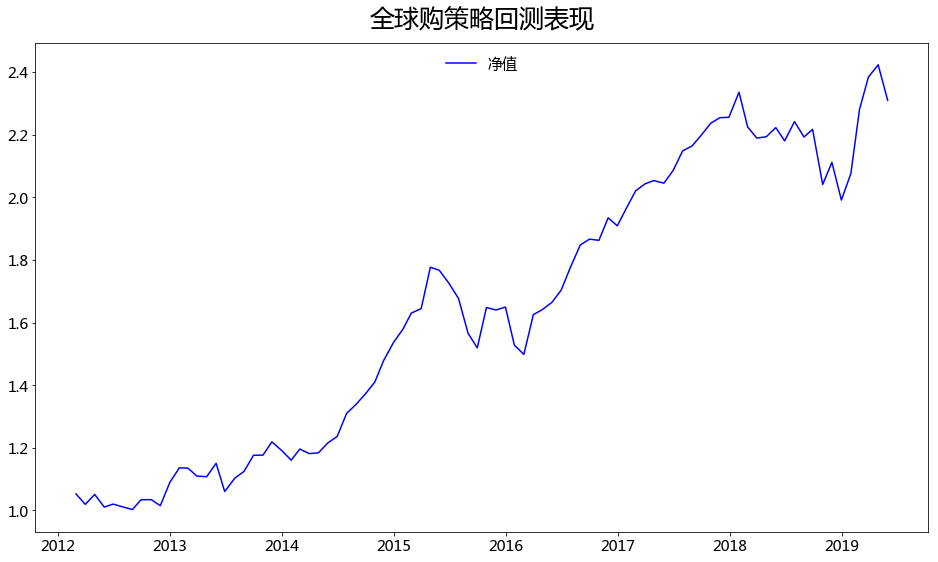

In [71]:
fig, ax = plt.subplots(figsize=(16, 9))

lns1 = ax.plot((1 + portfolio).cumprod(), color='blue', label=u'净值')

lns = lns1
labs = [l.get_label() for l in lns]
ax.legend(lns, labs, frameon=False, fontsize=15, loc='upper center', ncol=2, bbox_to_anchor=(0.5, 1.0))

ax.xaxis.set_tick_params(labelsize=15)
ax.yaxis.set_tick_params(labelsize=15)
vals = ax.get_yticks()
ax.set_yticklabels(['{:2.1f}'.format(x) for x in vals])

_ = ax.set_title(u'全球购策略回测表现', fontsize=25, y=1.02)

In [72]:
weight = weight.astype(np.float32)

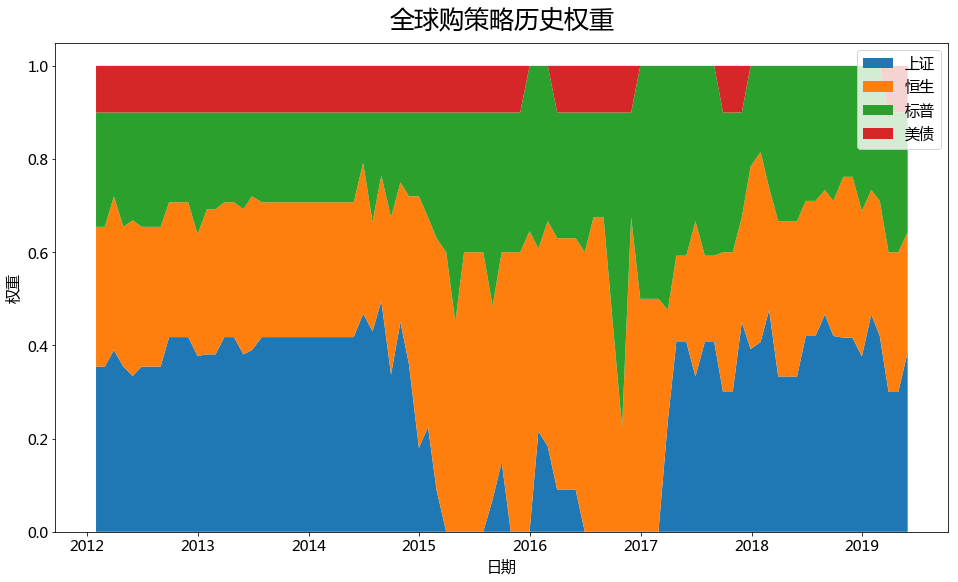

In [73]:
fig, ax = plt.subplots(figsize=(16, 9))
_ = ax.stackplot(weight.index, 
                 weight['Wind Index'],
                 weight['HSI Index'],
                 weight['SPXT  Index'],
                 weight['LUATTRUU Index'],
                 labels=[u'上证', u'恒生', u'标普', u'美债'])
ax.legend(fontsize=15)
ax.xaxis.set_tick_params(labelsize=15)
ax.yaxis.set_tick_params(labelsize=15)
ax.set_ylabel(u'权重', fontsize=15)
ax.set_xlabel(u'日期', fontsize=15)
_ = ax.set_title(u'全球购策略历史权重', fontsize=25, y=1.02)

In [74]:
weight.tail()

,Wind Index,HSI Index,SPXT Index,LUATTRUU Index
2019-01-31,0.466667,0.266667,0.266667,0.0
2019-02-28,0.420290,0.289855,0.289855,0.0
2019-03-29,0.300000,0.300000,0.300000,0.1
2019-04-30,0.300000,0.300000,0.300000,0.1
2019-05-31,0.385714,0.257143,0.257143,0.1


In [76]:
'%.8f'%(weight['Wind Index'][-1] / 2)

'0.19285715'

In [78]:
'%.8f'%(weight['HSI Index'][-1])

'0.25714287'

In [79]:
'%.8f'%(weight['SPXT  Index'][-1])

'0.25714287'

In [80]:
weight.to_excel('../data/weight.xlsx')